In [40]:
from netCDF4 import Dataset
import netCDF4 as netcdf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib as mpl
import cmocean as cmo

#mapping
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from scipy.interpolate import griddata

import xarray as xr
import xarray.ufuncs as xu

from matplotlib.path import Path
from matplotlib.patches import Polygon
from matplotlib import rc
font = {'weight':'bold'}
rc('font',**font)

#import geoviews as gv
#import holoviews as hv
#import geoviews.feature as gf
#gv.extension('bokeh', 'matplotlib')

In [2]:
def subset(lonw,lone,latn,lats,data,date1,date2):
    mask_lon = (data.lon >= lonw) & (data.lon <= lone)
    mask_lat = (data.lat >= lats) & (data.lat <= latn)
    %time new_data = data.sel(time=slice(date1,date2)).where(mask_lon & mask_lat, drop=True)
    return new_data

In [3]:
# import HFR dataset
aggr_url = "https://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USEGC/6km/hourly/RTV/HFRADAR_US_East_and_Gulf_Coast_6km_Resolution_Hourly_RTV_best.ncd"
data_h = xr.open_dataset(aggr_url)

# import CMEMS outputs
aggr_url = "./data/CMEMS-global-analysis-forecast-phy-001-024-hourly-u-v.nc"
data_m = xr.open_dataset(aggr_url)

In [24]:
# subset the dataset to the area and time period of interest

lonw, lone = -76.3, -73   # westernmonst and easternmost longitude
lats, latn = 36.5, 39.5 # southernmonst and northernmost latitude
date1 = "2020-05-01"    # initial date
date2 = "2020-06-01"    # final date

# create mask
mask_lon = (data_h.lon >= lonw) & (data_h.lon <= lone)
mask_lat = (data_h.lat >= lats) & (data_h.lat <= latn)

# subset
%time data_sub_h = data_h.sel(time=slice(date1, date2)).where(mask_lon & mask_lat, drop=True)

CPU times: user 462 ms, sys: 154 ms, total: 616 ms
Wall time: 21.2 s


In [25]:
mask_lon = (data_m.longitude >= lonw) & (data_m.longitude <= lone)
mask_lat = (data_m.latitude >= lats) & (data_m.latitude <= latn)
%time data_sub_m = data_m.sel(time=slice(date1, date2)).where(mask_lon & mask_lat, drop=True)

#data.groupby("time.month").mean(dim='time')
#data_sub # 'subseted' dataset

CPU times: user 26.7 ms, sys: 1.29 ms, total: 28 ms
Wall time: 25.8 ms


In [26]:
data_sub_m # 

<xarray.Dataset>
Dimensions:    (time: 744, depth: 1, latitude: 37, longitude: 37)
Coordinates:
  * depth      (depth) float32 0.494
  * latitude   (latitude) float32 36.5 36.58 36.67 36.75 ... 39.33 39.42 39.5
  * time       (time) datetime64[ns] 2020-05-01T00:30:00 ... 2020-05-31T23:30:00
  * longitude  (longitude) float32 -76.0 -75.92 -75.83 ... -73.17 -73.08 -73.0
Data variables:
    vo         (time, depth, latitude, longitude) float32 nan 0.4047 ... -0.047
    uo         (time, depth, latitude, longitude) float32 nan ... -0.04151
Attributes: (12/25)
    title:                              hourly mean fields from Global Ocean ...
    easting:                            longitude
    northing:                           latitude
    history:                            2021/08/05 00:11:43 MERCATOR OCEAN Ne...
    source:                             MERCATOR PSY4QV3R1
    institution:                        MERCATOR OCEAN
    ...                                 ...
    FROM_ORIGINAL_FILE__longitude_max:  179.91667
    FROM_ORIGINAL_FILE__latitude_min:   -80.0
    FROM_ORIGINAL_FILE__latitude_max:   90.0
    z_min:                              0.494025
    z_max:                              0.494025
    _CoordSysBuilder:                   ucar.nc2.dataset.conv.CF1Convention

In [46]:
# select a specific date and time
date = '2020-05-05T09:00:00'
datah = data_sub_h.sel(time=date,method='nearest')
datam = data_sub_m.sel(time=date,method='nearest') # mimics the model output - to be merged with Teresa and Maurício's code
# need to import the satellite data s well

In [47]:
datah.time, datam.time

(<xarray.DataArray 'time' ()>
 array('2020-05-05T09:00:00.000000000', dtype='datetime64[ns]')
 Coordinates:
     time      datetime64[ns] 2020-05-05T09:00:00
     time_run  datetime64[ns] ...
 Attributes:
     long_name:            Forecast time for ForecastModelRunCollection
     standard_name:        time
     _CoordinateAxisType:  Time,
 <xarray.DataArray 'time' ()>
 array('2020-05-05T09:30:00.000000000', dtype='datetime64[ns]')
 Coordinates:
     time     datetime64[ns] 2020-05-05T09:30:00
 Attributes:
     long_name:            Time (hours since 1950-01-01)
     standard_name:        time
     axis:                 T
     _CoordinateAxisType:  Time
     valid_min:            616512.5
     valid_max:            617255.5)

In [48]:
# calculate the magnitude of surface currents
magh = np.sqrt(datah.u.values**2+datah.v.values**2)
magm = np.sqrt(datam.uo.values**2+datam.vo.values**2)

# create the mesh
xh, yh = np.meshgrid(datah.lon.values,datah.lat.values)
xm, ym = np.meshgrid(datam.longitude.values,datam.latitude.values)

# mask data
magh = np.ma.masked_invalid(magh)
magm = np.ma.masked_invalid(magm).squeeze()
uh = np.ma.masked_invalid(datah.u.values)
vh = np.ma.masked_invalid(datah.v.values)
um = np.ma.masked_invalid(datam.uo.values).squeeze()
vm = np.ma.masked_invalid(datam.vo.values).squeeze()

In [49]:
uh = griddata((xh.ravel(),yh.ravel()),uh.ravel(),(xm,ym))
vh = griddata((xh.ravel(),yh.ravel()),vh.ravel(),(xm,ym))
magh = griddata((xh.ravel(),yh.ravel()),magh.ravel(),(xm,ym))

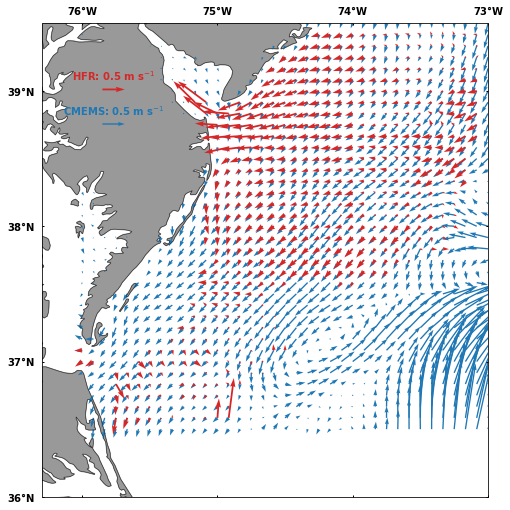

In [55]:
# conventional map (cartopy) - Panagiotis code

fig = plt.figure(figsize=(8,12))
proj = ccrs.PlateCarree()
ax=fig.add_subplot(1,1,1,projection=proj)
ax.set_extent([lonw, lone, lats, latn])

#mpl.rcParams['font.family'] = 'Arial'

ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())

stp = 1
lon_ticks = np.arange(int(lonw),int(lone)+stp) #[-75, -74, -73, -72, -71, -70, -69]
lat_ticks = np.arange(int(lats),int(latn)+stp)

ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())

ax.xaxis.set_tick_params(which='major', size=2., width=1, 
                         direction='in', top='on', pad=7)
ax.yaxis.set_tick_params(which='major', size=2., width=1, 
                         direction='in', right='on',pad=7)

ax.tick_params(labelleft=True,labelbottom=False,labeltop=True,labelright=False)  
ax.add_feature(cfeature.LAND.with_scale('10m'), facecolor='k', alpha=0.4)
ax.coastlines(resolution='10m',linewidth=0.3)

vmax = np.nanmean(magh)+2*np.nanstd(magh)
bounds = np.linspace(0,vmax,5)
norm = mpl.colors.Normalize(vmin=0., vmax=vmax)

# plot current vectors
c1, c2 = 'C3', 'C0'
cf1=ax.quiver(xm,ym,uh,vh,color=c1,#magh,cmap=cmo.cm.tempo,
             scale=10,width=.004,norm=norm,zorder=2)
cf2=ax.quiver(xm,ym,um,vm,color=c2,#magm,cmap=cmo.cm.amp,
             scale=10,width=.003,norm=norm,zorder=1)
# add the scale for the currents magnitude
qk = ax.quiverkey(cf1, 0.25, 0.7, 0.5, label='HFR: 0.5 m s$^{-1}$', labelpos='N',
                   coordinates='figure', labelcolor=c1)
qk = ax.quiverkey(cf2, 0.25, 0.66, 0.5, label='CMEMS: 0.5 m s$^{-1}$', labelpos='N',
                   coordinates='figure', labelcolor=c2)
# add colorbar
#cax,kw = mpl.colorbar.make_axes(ax,location='bottom',pad=0.05,aspect=50)
#out=fig.colorbar(cf1,cax=cax,ticks=bounds,extend='max',format='%.2f',**kw)
#out.set_label('Surface Velocity (m s$^{-1}$)',size=10)
#out.ax.tick_params(direction='in',size=2., width=1)

#plt.savefig('hf_radar.svg', format='svg', transparent=False, dpi=300, bbox_inches='tight')
plt.savefig('map_v1.png', format='png', transparent=False, dpi=300, bbox_inches='tight')

In [10]:
proj = ccrs.PlateCarree()

stph, stpm = 2, 2 #subsample the vectorfield

# compute angles of the vector
angleh = np.pi/2 - np.arctan2(uh/magh, vh/magh)
anglem = np.pi/2 - np.arctan2(um/magm, vm/magm)

# holoviews objects
#hfr = gv.VectorField((xm[::stph,::stph], ym[::stph,::stph],           # HFR vectorfield
#                      angleh[::stph,::stph], magh[::stph,::stph]), 
#                     crs=proj)
#mdl = gv.VectorField((xm[::stpm,::stpm], ym[::stpm,::stpm],           # 'model' vectorfield
#                    anglem[::stpm,::stpm], magm[::stpm,::stpm]), 
#                     crs=proj)

In [70]:
#tiles = gv.tile_sources.CartoLight                # map object - I really didn't like any of them

# plot interactive map
#hfr.opts(magnitude='Magnitude',color='red',     
#         padding=.1, colorbar=True, line_width=2,
#         height=350, width=350) * \
#mdl.opts(magnitude='Magnitude',color='black',
#         padding=.1, colorbar=True, line_width=2,
#         height=350, width=350) * tiles.opts(alpha=1,fontsize='0pt')
# not sure which colors to choose.... bur colormaps for each dataset does not look good
#arquivo track satélite 228!!

:Overlay
   .VectorField.I  :VectorField   [Longitude,Latitude]   (Angle,Magnitude)
   .VectorField.II :VectorField   [Longitude,Latitude]   (Angle,Magnitude)
   .WMTS.I         :WMTS   [Longitude,Latitude]

In [127]:
hv.help(hv.Tiles)

Tiles

Online example: http://holoviews.org/reference/elements/bokeh/Tiles.html

-------------
Style Options
-------------

	alpha, level, max_zoom, min_zoom, render_parents, smoothing

(Consult bokeh's documentation for more information.)

------------
Plot Options
------------

The plot options are the parameters of the plotting class:

Parameters of 'TilePlot'

Parameters changed from their default values are marked in red.
Soft bound values are marked in cyan.
C/V= Constant/Variable, RO/RW = ReadOnly/ReadWrite, AN=Allow None

Name                                 Value                         Type         Bounds     Mode  

fontsize                       {'title': '12pt'}                Parameter                V RW AN 
fontscale                             None                        Number                 V RW AN 
show_title                            True                       Boolean        (0, 1)     V RW  
title                    '{label} {group} {dimensions}'           Strin

In [88]:
# time holograph test
#kdims = ['time', 'lon', 'lat']
#vdims = ['u','v']
#data_gv = gv.Dataset(data_sub, kdims=kdims, vdims=vdims)
#hv.Dimension.type_formatters[np.datetime64] = '%Y-%m-%d'